In [ ]:
# !pip install -U openassetpricing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
from datetime import datetime
import openassetpricing as openap

# -------------------- Helper Function --------------------
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# -------------------- Parameters --------------------
signallist = ['IndIPO','BM']
ensure_dir('temp')

# -------------------- Initialize OpenAP and Download Signal Doc --------------------
openap_obj = openap.OpenAP(2022)  # using the latest release by default
signaldoc = openap_obj.dl_signal_doc('pandas')

print("Available signals:")
print(signaldoc[['Acronym', 'Authors', 'LongDescription']].head(20))

# -------------------- Download Portfolio Data --------------------
# Download OSAP portfolio returns for the IndIPO signal
port_osap = openap_obj.dl_port('op', 'pandas', signallist)
port_osap['date'] = pd.to_datetime(port_osap['date'])

# Reduce to LS portfolios (openap provides multiple portfolio versions for each anomaly on each date)
port_osap.query('port== "LS"', inplace=True)

# -------------------- Add Mkt-Rf returns --------------------

import pandas_datareader 
pandas_datareader.famafrench.get_available_datasets()
# Developed_3_Factors

# download F-F_Research_Data_Factors
ff = pandas_datareader.get_data_famafrench('F-F_Research_Data_Factors',start=1950,end=2024)[0]
ff = ff.reset_index().rename(columns={'Date':'yearm'})

# convert ff['Date'] from period[M] to YYYYMM number, to merge with port_osap
ff['yearm'] = ff['yearm'].dt.year * 100 + ff['yearm'].dt.month

# Create a mapping from dates in port_osap to a 'yearm' format (e.g. 202103 for March 2021)
date_mapping = port_osap[['date']].drop_duplicates().copy()
date_mapping['yearm'] = date_mapping['date'].dt.year * 100 + date_mapping['date'].dt.month
date_mapping, ff

# Merge into the FF data the port_osap dates for each money (last trading date of that month/year)
ff = pd.merge(ff, date_mapping, on='yearm', how='inner')

# For our purposes, we only need the date and the market excess return (Mkt-RF)
ff_processed = ff[['date', 'Mkt-RF']].copy()
ff_processed.rename(columns={'Mkt-RF': 'ret'}, inplace=True)
ff_processed['signalname'] = 'mkt_rf'
ff_processed

# -------------------- Combine Data -------------------- #
# NOTE: this drops all variables except date, ret, and signalname 

port_osap = pd.concat([port_osap[['date', 'ret', 'signalname']],
              ff_processed[['date', 'ret', 'signalname']]], ignore_index=True)

display(port_osap.groupby('signalname').describe()['ret'])


c:\Users\DonsLaptop\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Available signals:
               Acronym                         Authors  \
0     AbnormalAccruals                             Xie   
1             Accruals                           Sloan   
2           AccrualsBM                  Bartov and Kim   
3            Activism1                Cremers and Nair   
4                   AM                 Fama and French   
5      AnalystRevision     Hawkins, Chamberlin, Daniel   
6   AnnouncementReturn  Chan, Jegadeesh and Lakonishok   
7          AssetGrowth        Cooper, Gulen and Schill   
8      BetaLiquidityPS            Pastor and Stambaugh   
9         BetaTailRisk                 Kelly and Jiang   
10             betaVIX                      Ang et al.   
11                  BM   Rosenberg, Reid, and Lanstein   
12               BMdec                 Fama and French   
13        BookLeverage                 Fama and French   
14               BPEBM     Penman, Richardson and Tuna   
15                Cash                         Palazz

C:\Users\DonsLaptop\AppData\Local\Temp\ipykernel_6536\2924589412.py:42: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pandas_datareader.get_data_famafrench('F-F_Research_Data_Factors',start=1950,end=2024)[0]
C:\Users\DonsLaptop\AppData\Local\Temp\ipykernel_6536\2924589412.py:42: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pandas_datareader.get_data_famafrench('F-F_Research_Data_Factors',start=1950,end=2024)[0]


,count,mean,min,25%,50%,75%,max,std
signalname,,,,,,,,
BM,726.0,0.949682,-25.506774,-1.583586,0.596431,2.966628,40.550071,4.805902
IndIPO,560.0,0.457268,-18.936888,-1.083949,0.330338,2.049877,15.404419,3.410457
mkt_rf,726.0,0.581515,-23.240000,-1.960000,1.010000,3.400000,16.100000,4.453374


In [2]:
def plot_anomaly(signal, years_presamp=15, plot_end=2023):
    '''
    Plot the cumulative long-short return of a given signal, with vertical lines
    indicating the publication date and sample end date of the signal's paper.
    
    Parameters:
    signal (str): The signal to plot.
    years_presamp (int): The number of years to go back from the sample end date. 
                         If None, use the sample start date for the publication.
    plot_end (int): The year to end the plot. If None, use the most recent year in the data.
    '''

    # -------------------- Get Signal Documentation for IndIPO --------------------
    doctarget = signaldoc[signaldoc['Acronym'] == signal].iloc[0]
    # Publication date is the December 31 of the paper's year
    doctarget_pubdate = pd.to_datetime(str(doctarget['Year']) + '-12-31')
    # Publication's Sample end date is the December 31 of the SampleEndYear
    doctarget_sampend = pd.to_datetime(str(doctarget['SampleEndYear']) + '-12-31')
    # Build a paper name for annotation purposes
    papername = f"{doctarget['Authors']} {doctarget['Year']} ({signal})"
    
    if years_presamp is None:
        start_date = pd.to_datetime(str(doctarget['SampleStartYear']) + '-12-31')
    else:
        start_date = doctarget_sampend - pd.DateOffset(years=years_presamp)
        
    end_date = pd.to_datetime(str(plot_end) + '-12-31')
        
        
    # -------------------- Filter Data --------------------
    plotme = port_osap[(port_osap['date'] >= start_date) & (port_osap['date'] <= end_date)].copy()
    plotme = plotme[plotme['signalname'] == signal]
    plotme['cret'] = (1 + plotme['ret']/100).cumprod()
    
    # Determine a y-axis location for annotating the vertical lines (75% of the way from 1 to the max)
    yloc = (plotme['cret'].max() - 1) * 0.75
        
    # -------------------- Plot Using Seaborn --------------------
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=plotme, x='date', y='cret', linewidth=1.2)
    plt.xlabel('')
    plt.ylabel('Cummulative Long-Short Return')

    if signal not in ['Mkt-Rf']:
        # Add a red vertical line at the publication date and annotate it
        plt.axvline(doctarget_pubdate, color='red')
        plt.text(doctarget_pubdate, yloc, "\n" + papername + " Published",
                color="red", rotation=90, verticalalignment='center')

        # Add a blue vertical line at the sample end date and annotate it
        plt.axvline(doctarget_sampend, color='blue')
        plt.text(doctarget_sampend, yloc, "\n" + papername + " Sample Ends",
                color="blue", rotation=90, verticalalignment='center')

    plt.legend(title='')
    plt.tight_layout()
    plt.show()
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


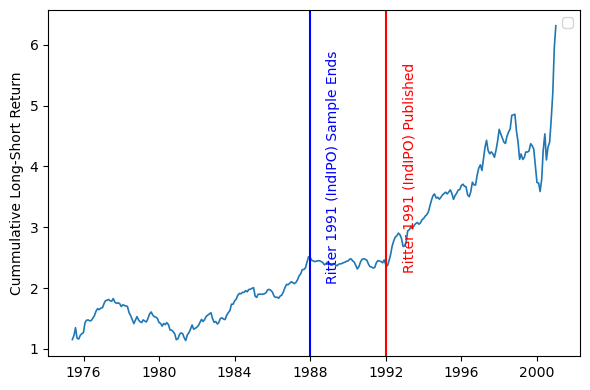

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


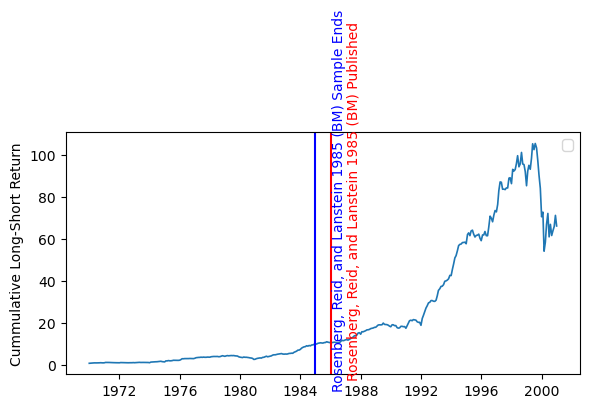

In [3]:
plot_anomaly('IndIPO',plot_end=2000)
plot_anomaly('BM', plot_end=2000)


<Axes: xlabel='date', ylabel='ret'>

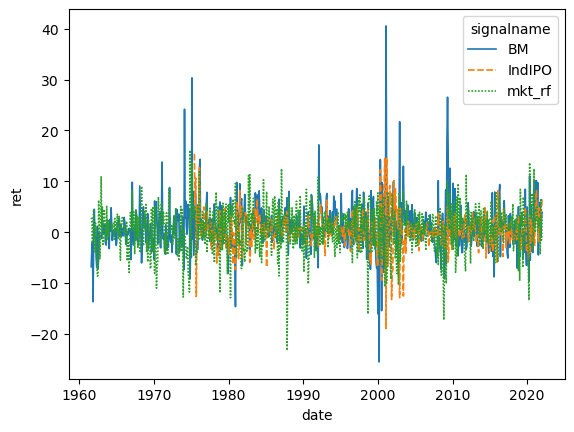

In [4]:
sns.lineplot(data=port_osap,x='date',y='ret',hue='signalname',style='signalname',linewidth=1.2)